In this post we'll continue our SC2 replay research, [started last time](bayes-sc2-1.ipynb). You may want to go back to that and pick up on the terminology!

To recap: we used replay data from my SC2 games over 2019 to estimate a "true MMR" value and infer the size of per-game fluctuations. This time, we'll redo that analysis, except to get something more useful: we'll look at the three matchups I played and infer separate MMR values for each of those. Let's dig into it!

<!-- TEASER_END -->

I'll redo the basic data cleaning steps here. If any of this is confusing, reviewing [the previous post](../bayes-sc2-part-1) might really be a good idea - or you could ask a question below, as always!

If you take a close look, you might also find a teaser for one of the next posts in this series here :)

In [42]:
import pandas as pd
import altair

def MMR_winrate(diff):
    return 1 / (1 + 10**(-diff/880))

df = pd.read_csv("https://raw.githubusercontent.com/StanczakDominik/stanczakdominik.github.io/src/files/replays.csv", index_col=0)
df['time_played_at'] = pd.to_datetime(df.time_played_at)
df = df.sort_values('time_played_at')
for column in ['race', 'enemy_race', 'map_name']:
    df[column] = pd.Categorical(df[column])
df['enemy_mmr'] = df['mmr'] - df['mmr_diff']
df['expected_winrate'] = MMR_winrate(df.mmr_diff)
all_data = df[(df.mmr > 0) & (df.enemy_mmr > 0) & (df.race == "Protoss") & (df.duration > 10)]
all_data = all_data.rename({"enemy_nickame": "enemy_nickname"}, axis=1) # whoops
data = all_data[(all_data['time_played_at'] > '2019-01-01') & (all_data['time_played_at'] < '2020-01-01')]
data

,time_played_at,win,race,enemy_race,mmr,mmr_diff,enemy_nickname,map_name,duration,enemy_mmr,expected_winrate
8,2019-10-06 12:36:36+00:00,True,Protoss,Protoss,3826,78,vasea,World of Sleepers LE,743,3748,0.550847
325,2019-10-08 19:33:28+00:00,False,Protoss,Protoss,3893,-53,Wavelength,Ephemeron LE,254,3946,0.465386
54,2019-10-10 07:41:27+00:00,False,Protoss,Zerg,3828,26,PereiRa,Winter's Gate LE,45,3802,0.517001
346,2019-10-10 07:55:19+00:00,True,Protoss,Zerg,3760,-56,&lt;PROOO&gt;<sp/>Jesperpro,Thunderbird LE,801,3816,0.463433
138,2019-10-10 20:42:11+00:00,True,Protoss,Protoss,3827,126,Pippuri,Acropolis LE,697,3701,0.581684
...,...,...,...,...,...,...,...,...,...,...,...
391,2019-12-27 20:24:27+00:00,False,Protoss,Zerg,3933,-100,HiveMind,World of Sleepers LE,262,4033,0.434956
25,2019-12-27 20:40:39+00:00,True,Protoss,Zerg,3914,0,Racin,Nightshade LE,911,3914,0.500000
208,2019-12-27 21:24:06+00:00,True,Protoss,Terran,3936,-41,&lt;DemuCl&gt;<sp/>Jazzz,Nightshade LE,1277,3977,0.473206
59,2019-12-28 20:58:25+00:00,True,Protoss,Terran,3959,22,rOoSter,Simulacrum LE,76,3937,0.514387


Let's visualize the games on a per-matchup MMR vs enemy MMR basis. I added some fancy Altair selection magic, so you can look at winrates in specific MMR ranges.

In [15]:
brush = altair.selection(type='interval')
scatter = altair.Chart(data).mark_circle().encode(
    altair.X('enemy_mmr',
             scale=altair.Scale(zero=False)),
    altair.Y('mmr',
             scale=altair.Scale(zero=False)),
    facet='enemy_race',
    size='expected_winrate',
    color='win',
    tooltip='enemy_nickname',
).add_selection(brush)

bar = altair.Chart(data).mark_bar().encode(
    x=altair.X('mean(win):Q', scale=altair.Scale(domain=(0, 1))),
    y='enemy_race:O',
).transform_filter(brush)

scatter & bar

alt.VConcatChart(...)

# Separate matchup MMRs

This is where the magic starts. Where, before, we had a single MMR estimation, we'll now have three, one for each matchup:
$$\mu^n \sim \text{Normal}(4000, 300) \text{ for } n \text{ in } \{1, 2, 3\}$$

And likewise for the fluctuation value:
$$\sigma^n \sim \text{HalfNormal}(100)$$

And that, honestly, is about it! When I realized it, I wanted to title this post "How Can It Be That Simple, Like, What The Hell". But I did have to tinker with the model for a good while to find out the optimal way of doing things. It turns out the first idea I had was optimal. Who knew.


We'll use some fancy new PyMC3 3.9 and ArviZ 0.8.3 functionality to replace the old `shapes` arguments with `dims`, for cleaner code.

Note: to reproduce, use the GitHub master release of ArviZ for now.

In [18]:
import pymc3 as pm
import arviz as az

# fancy new functionality for xarray output - I'll explain later!
coords = {
    "replay": data.index,
    "race": ["Terran", "Protoss", "Zerg"],
}

We now assign the new priors for $\mu^n$ and $\sigma^n$, three of each - and then we'll add a helper variable for each of the replays. Note how
the new syntax is a good bit cleaner than hardcoding the shapes in.

In [19]:
with pm.Model(coords=coords) as split_model:
    mmr_μ_matchup = pm.Normal('μ', 4000, 300, dims='race')
    mmr_σ_matchup = pm.HalfNormal('σ', 100, dims='race')
    mmr_σ_norm = pm.Normal('helper', 0, 1, dims='replay')

And the next change we have to make is indexing the per-race average and fluctuation values based on the enemy races, so that each game in our dataset gets the MMR for its particular matchup.

We'll have to assign a numerical index for each possible enemy race. We'll choose zeroes for Terran and two for Zerg, so that, at least in indices, Protoss [can be number one](https://youtu.be/PfYnvDL0Qcw?t=28).

In [20]:
race_encoding ={"Terran": 0,
                "Protoss": 1,
                "Zerg": 2} 

with split_model:
    enemy_races = pm.Data("enemy_race", data.enemy_race.map(race_encoding).astype(int), dims='replay')
    mmr = pm.Deterministic('MMR', mmr_μ_matchup[enemy_races] + mmr_σ_matchup[enemy_races] * mmr_σ_norm, dims='replay')

And now it's smooth sailing from here on out! I forgot to add it last time, but PyMC3 can create a neat graph for your model using GraphViz.
If I had remembered to do so, the only difference between this model and ours would be the 3 for $\mu, \sigma$ - since we now have three of each - and adding the `enemy_race` as `pymc3.Data`.

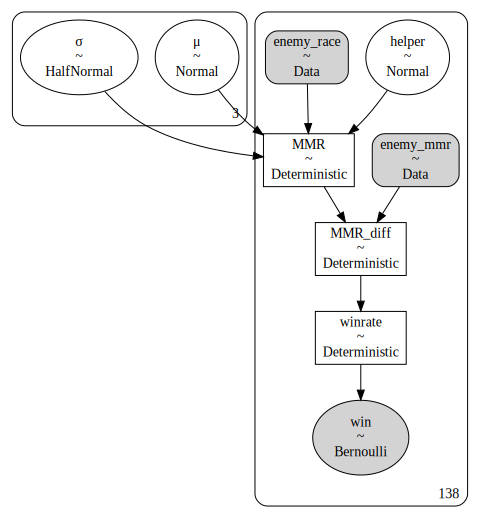

In [21]:
with split_model:
    enemy_mmr = pm.Data("enemy_mmr", data.enemy_mmr, dims='replay')
    diffs = pm.Deterministic('MMR_diff', mmr - enemy_mmr, dims = 'replay')
    p = pm.Deterministic('winrate', MMR_winrate(diffs), dims = 'replay')
    wl = pm.Bernoulli('win', p=p, observed=data.win, dims = 'replay')
pm.model_to_graphviz(split_model)

## First run

And now, let's `sample`! We'll add a predictive prior and posterior sample: this lets us easily see what sort of data we'd see from our initial assumptions and from the fully "learned" ("taught"?) model.

In [28]:
predictive_var_names = "win μ σ winrate".split()
with split_model:
    trace = pm.sample(2000, tune=2000, chains=4, random_seed=1)
    output = az.from_pymc3(trace=trace,
                           prior=pm.sample_prior_predictive(2000 , var_names=predictive_var_names, random_seed=1),
                           posterior_predictive=pm.sample_posterior_predictive(trace, var_names=predictive_var_names, random_seed=1),
                          )
output

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [helper, σ, μ]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 18 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

That `InferenceData` ArviZ object lets us see everything the model picked up. It's really, really neat.

We had a few divergences; not too many, though Let's take a look at how the sampling went:

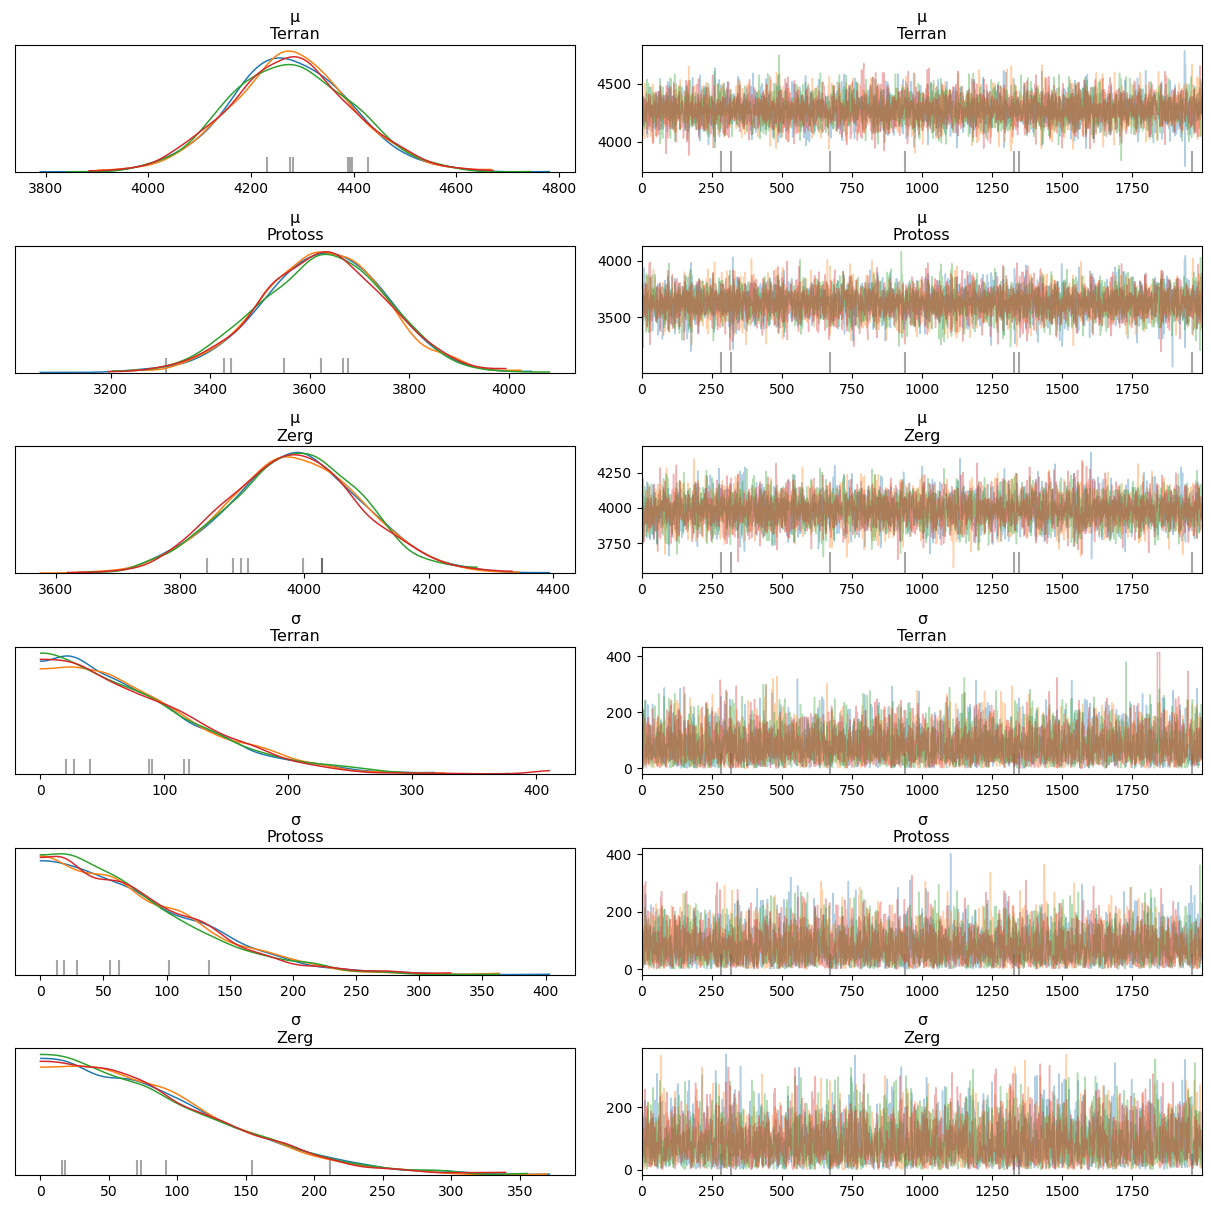

In [29]:
var_names = "μ σ".split()
az.plot_trace(output, var_names=var_names);

In [35]:
az.summary(output, var_names = var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ[0],4275.797,116.495,4066.919,4504.642,1.418,1.005,6750.0,6715.0,6767.0,4891.0,1.0
μ[1],3625.102,122.610,3403.476,3865.610,1.407,0.995,7597.0,7597.0,7622.0,4916.0,1.0
μ[2],3984.044,105.523,3785.491,4182.183,1.353,0.957,6082.0,6082.0,6082.0,4802.0,1.0
σ[0],78.531,59.788,0.019,184.598,0.819,0.692,5331.0,3737.0,4413.0,3198.0,1.0
σ[1],76.320,58.370,0.030,180.889,0.773,0.547,5699.0,5699.0,4607.0,3176.0,1.0
σ[2],85.882,64.475,0.266,201.367,0.970,0.686,4420.0,4420.0,3717.0,3351.0,1.0


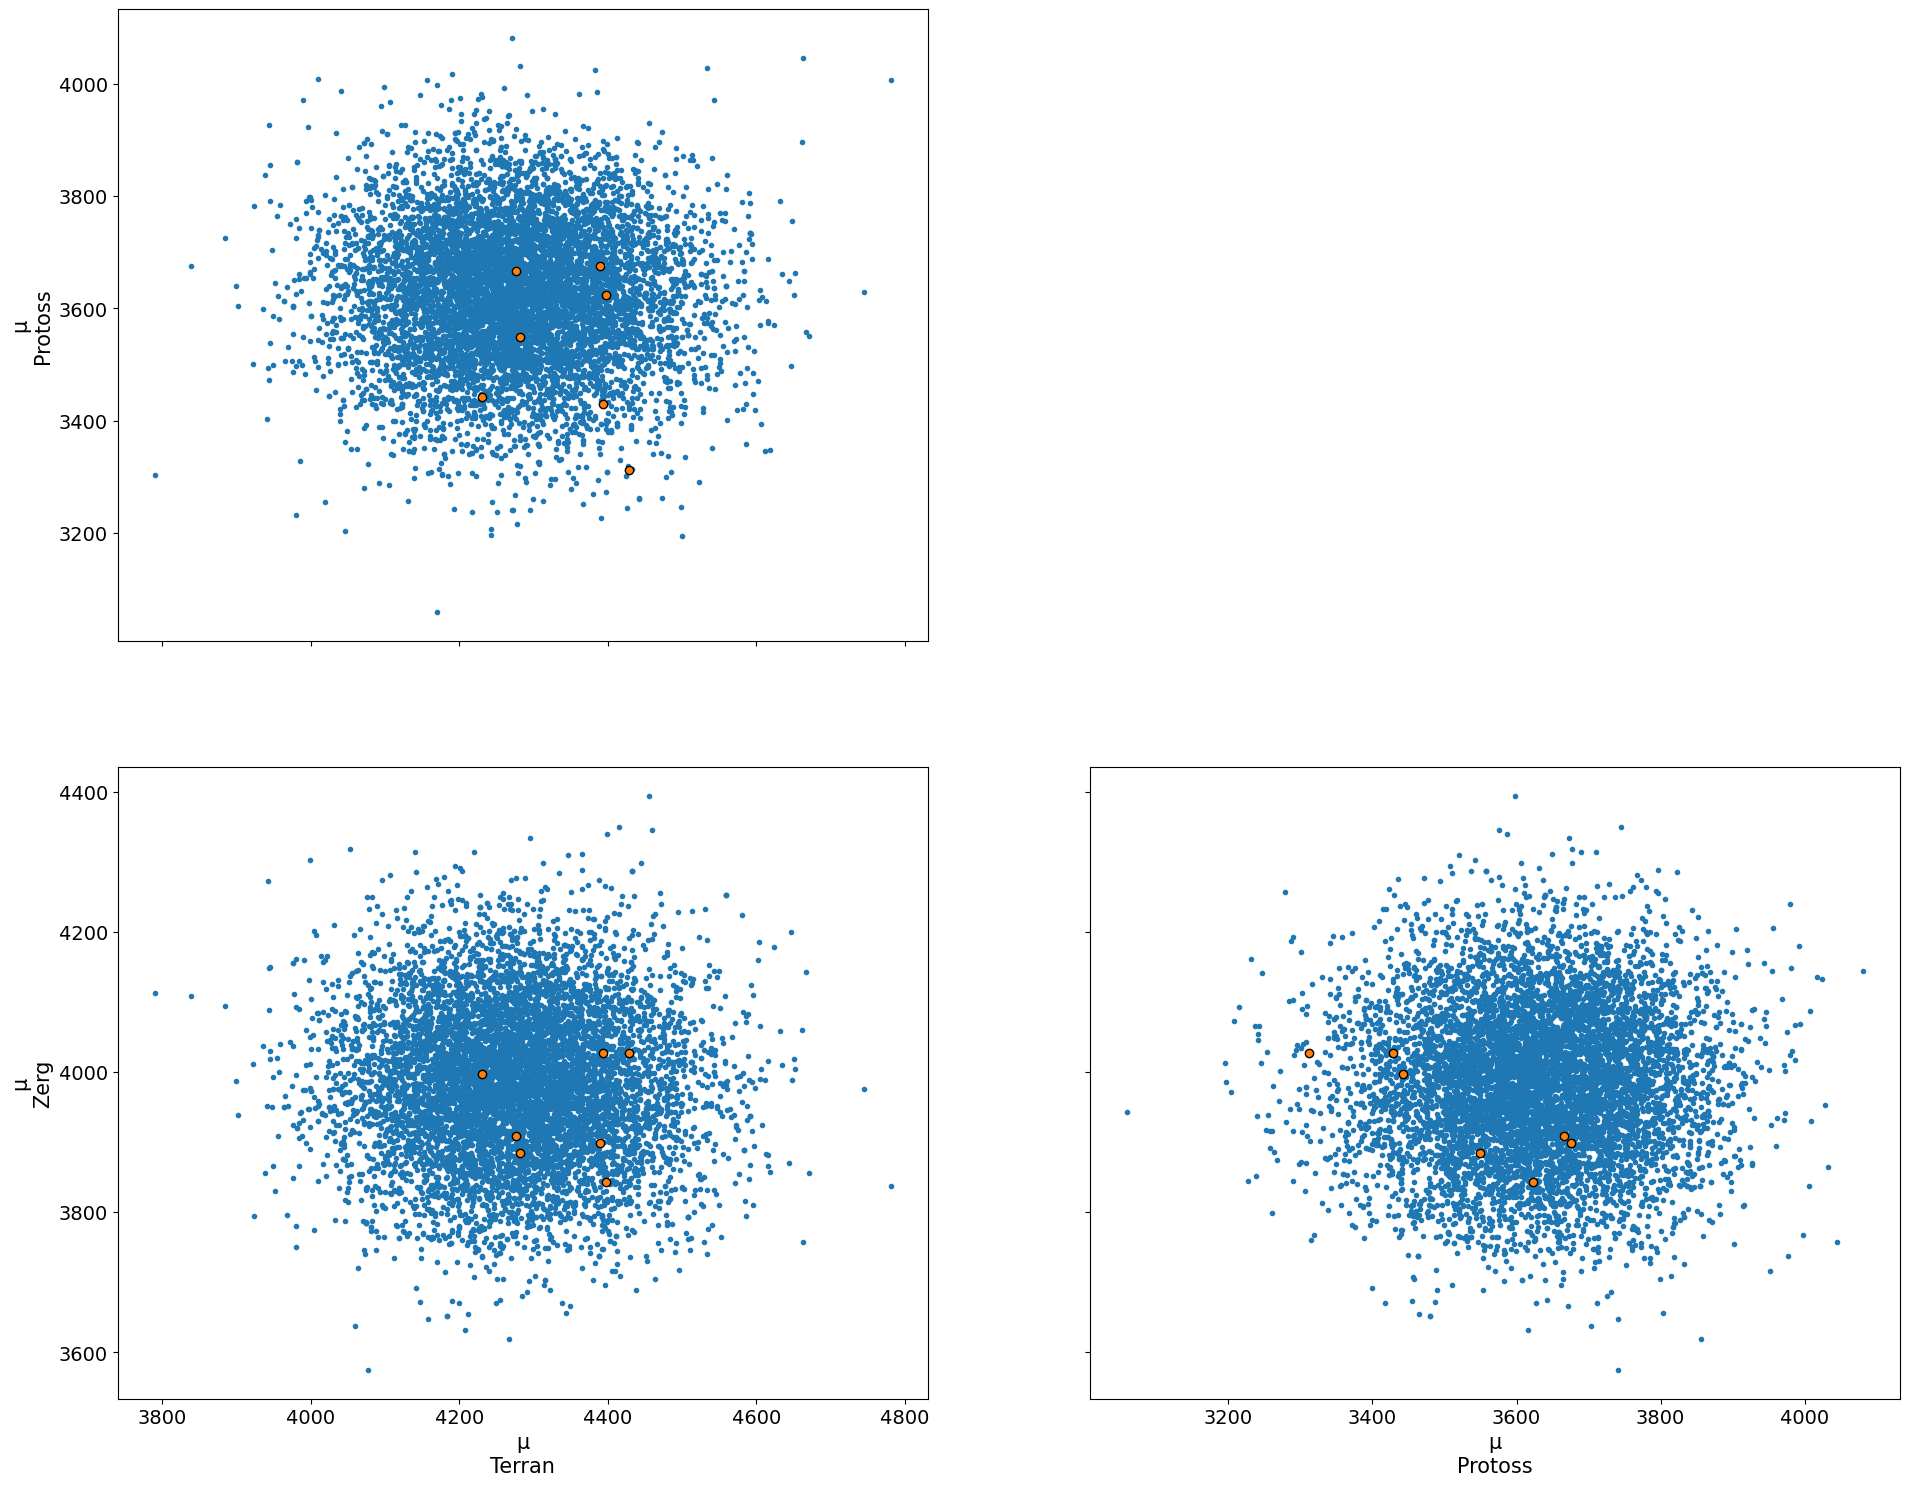

In [33]:
az.plot_pair(output, var_names='μ', divergences=True);

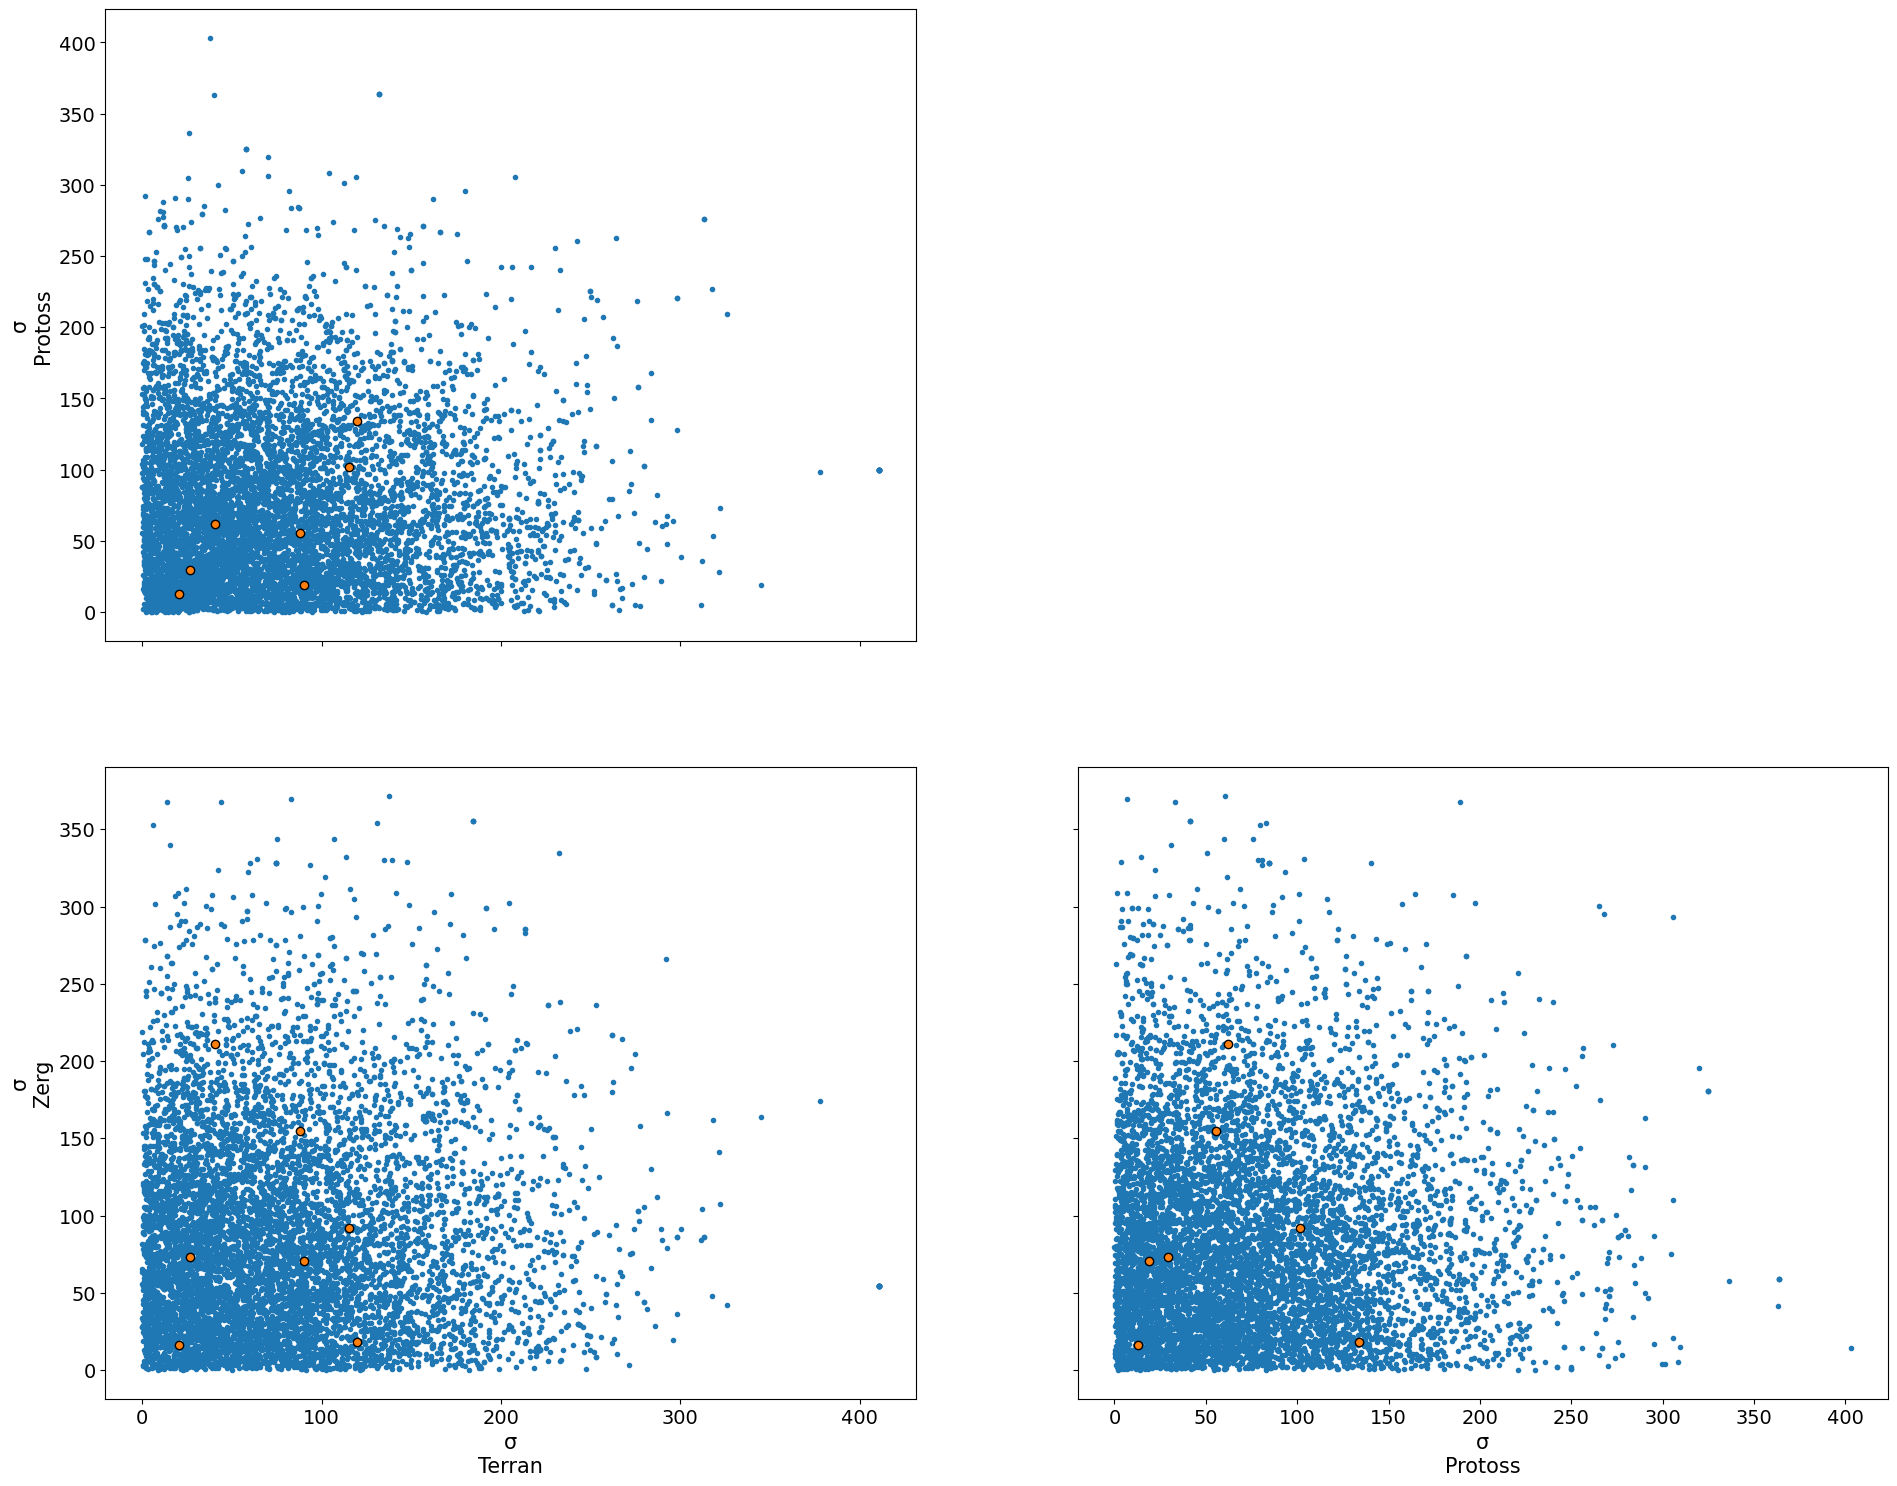

In [32]:
az.plot_pair(output, var_names='σ', divergences=True);

# Slower sampling

Once again, we have a few divergences, but they don't seem to say anything concrete as far as I can tell. These could be false positives; we could increase `target_accept`, which is basically an inverse timestep for the simulation (shorter timesteps usually mean larger accuracy at the cost of more computational time).

In [38]:
with split_model:
    trace = pm.sample(2000, tune=2000, chains=4, random_seed=1, target_accept=0.9)
    output = az.from_pymc3(trace=trace,
                           prior=pm.sample_prior_predictive(2000 , var_names=predictive_var_names, random_seed=1),
                           posterior_predictive=pm.sample_posterior_predictive(trace, var_names=predictive_var_names, random_seed=1),
                          )
output

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [helper, σ, μ]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 34 seconds.


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

Looks like that helped!

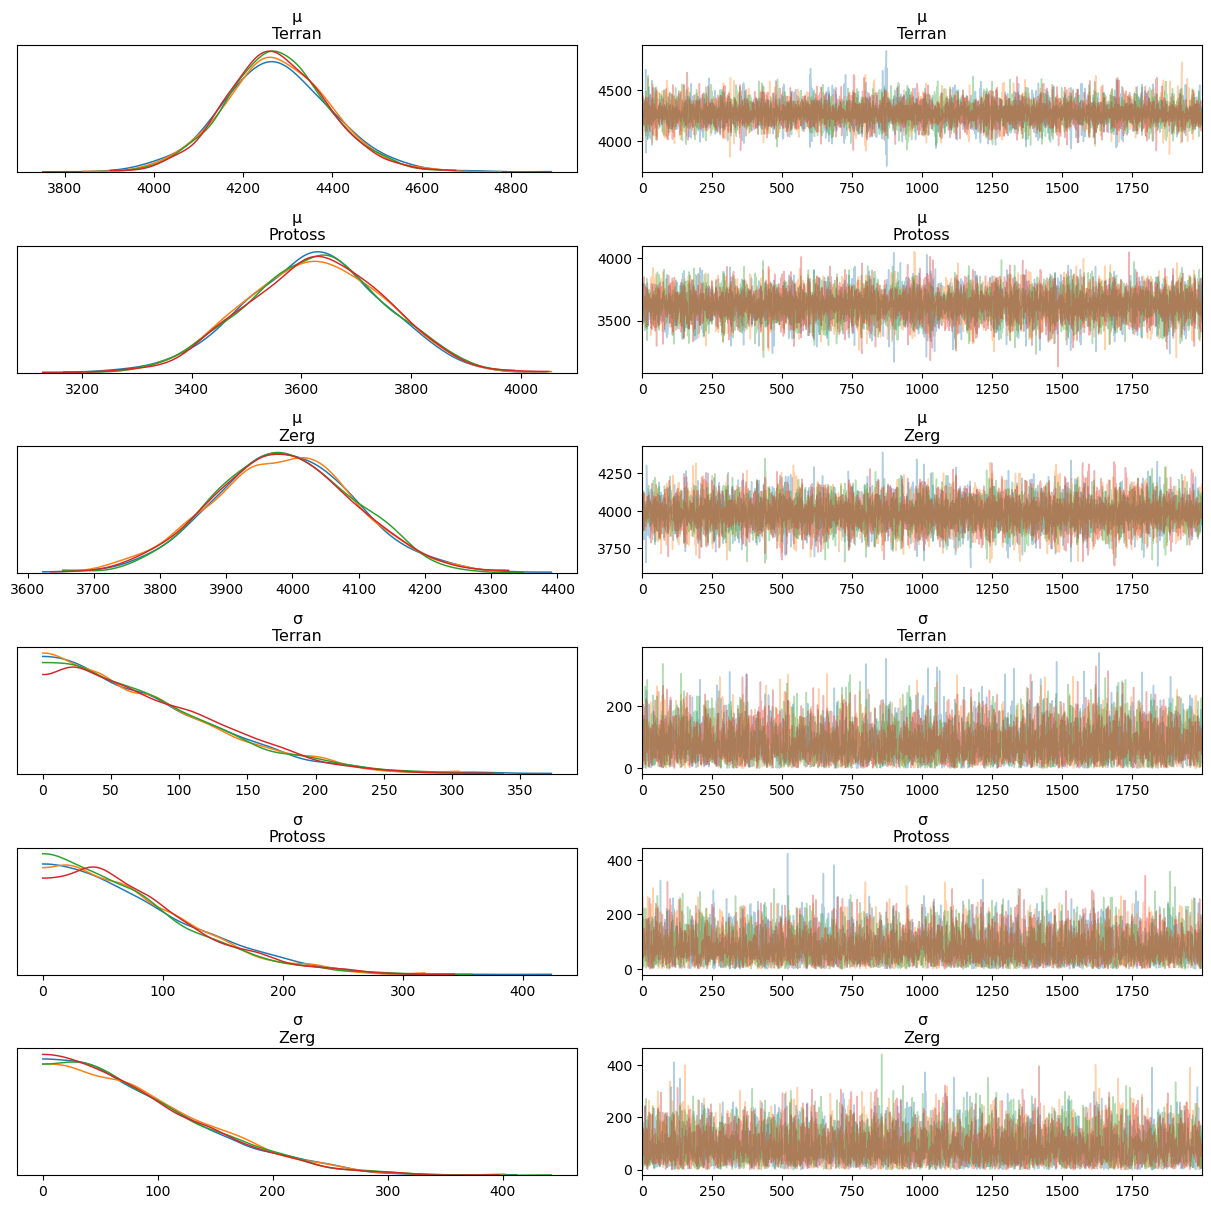

In [39]:
az.plot_trace(output, var_names=var_names);

We can also plot the posteriors and the Highest Density Intervals, whose value for the threshold of 94% says that our model is 94% sure my PvT average MMR is located between 4045 and 4489:

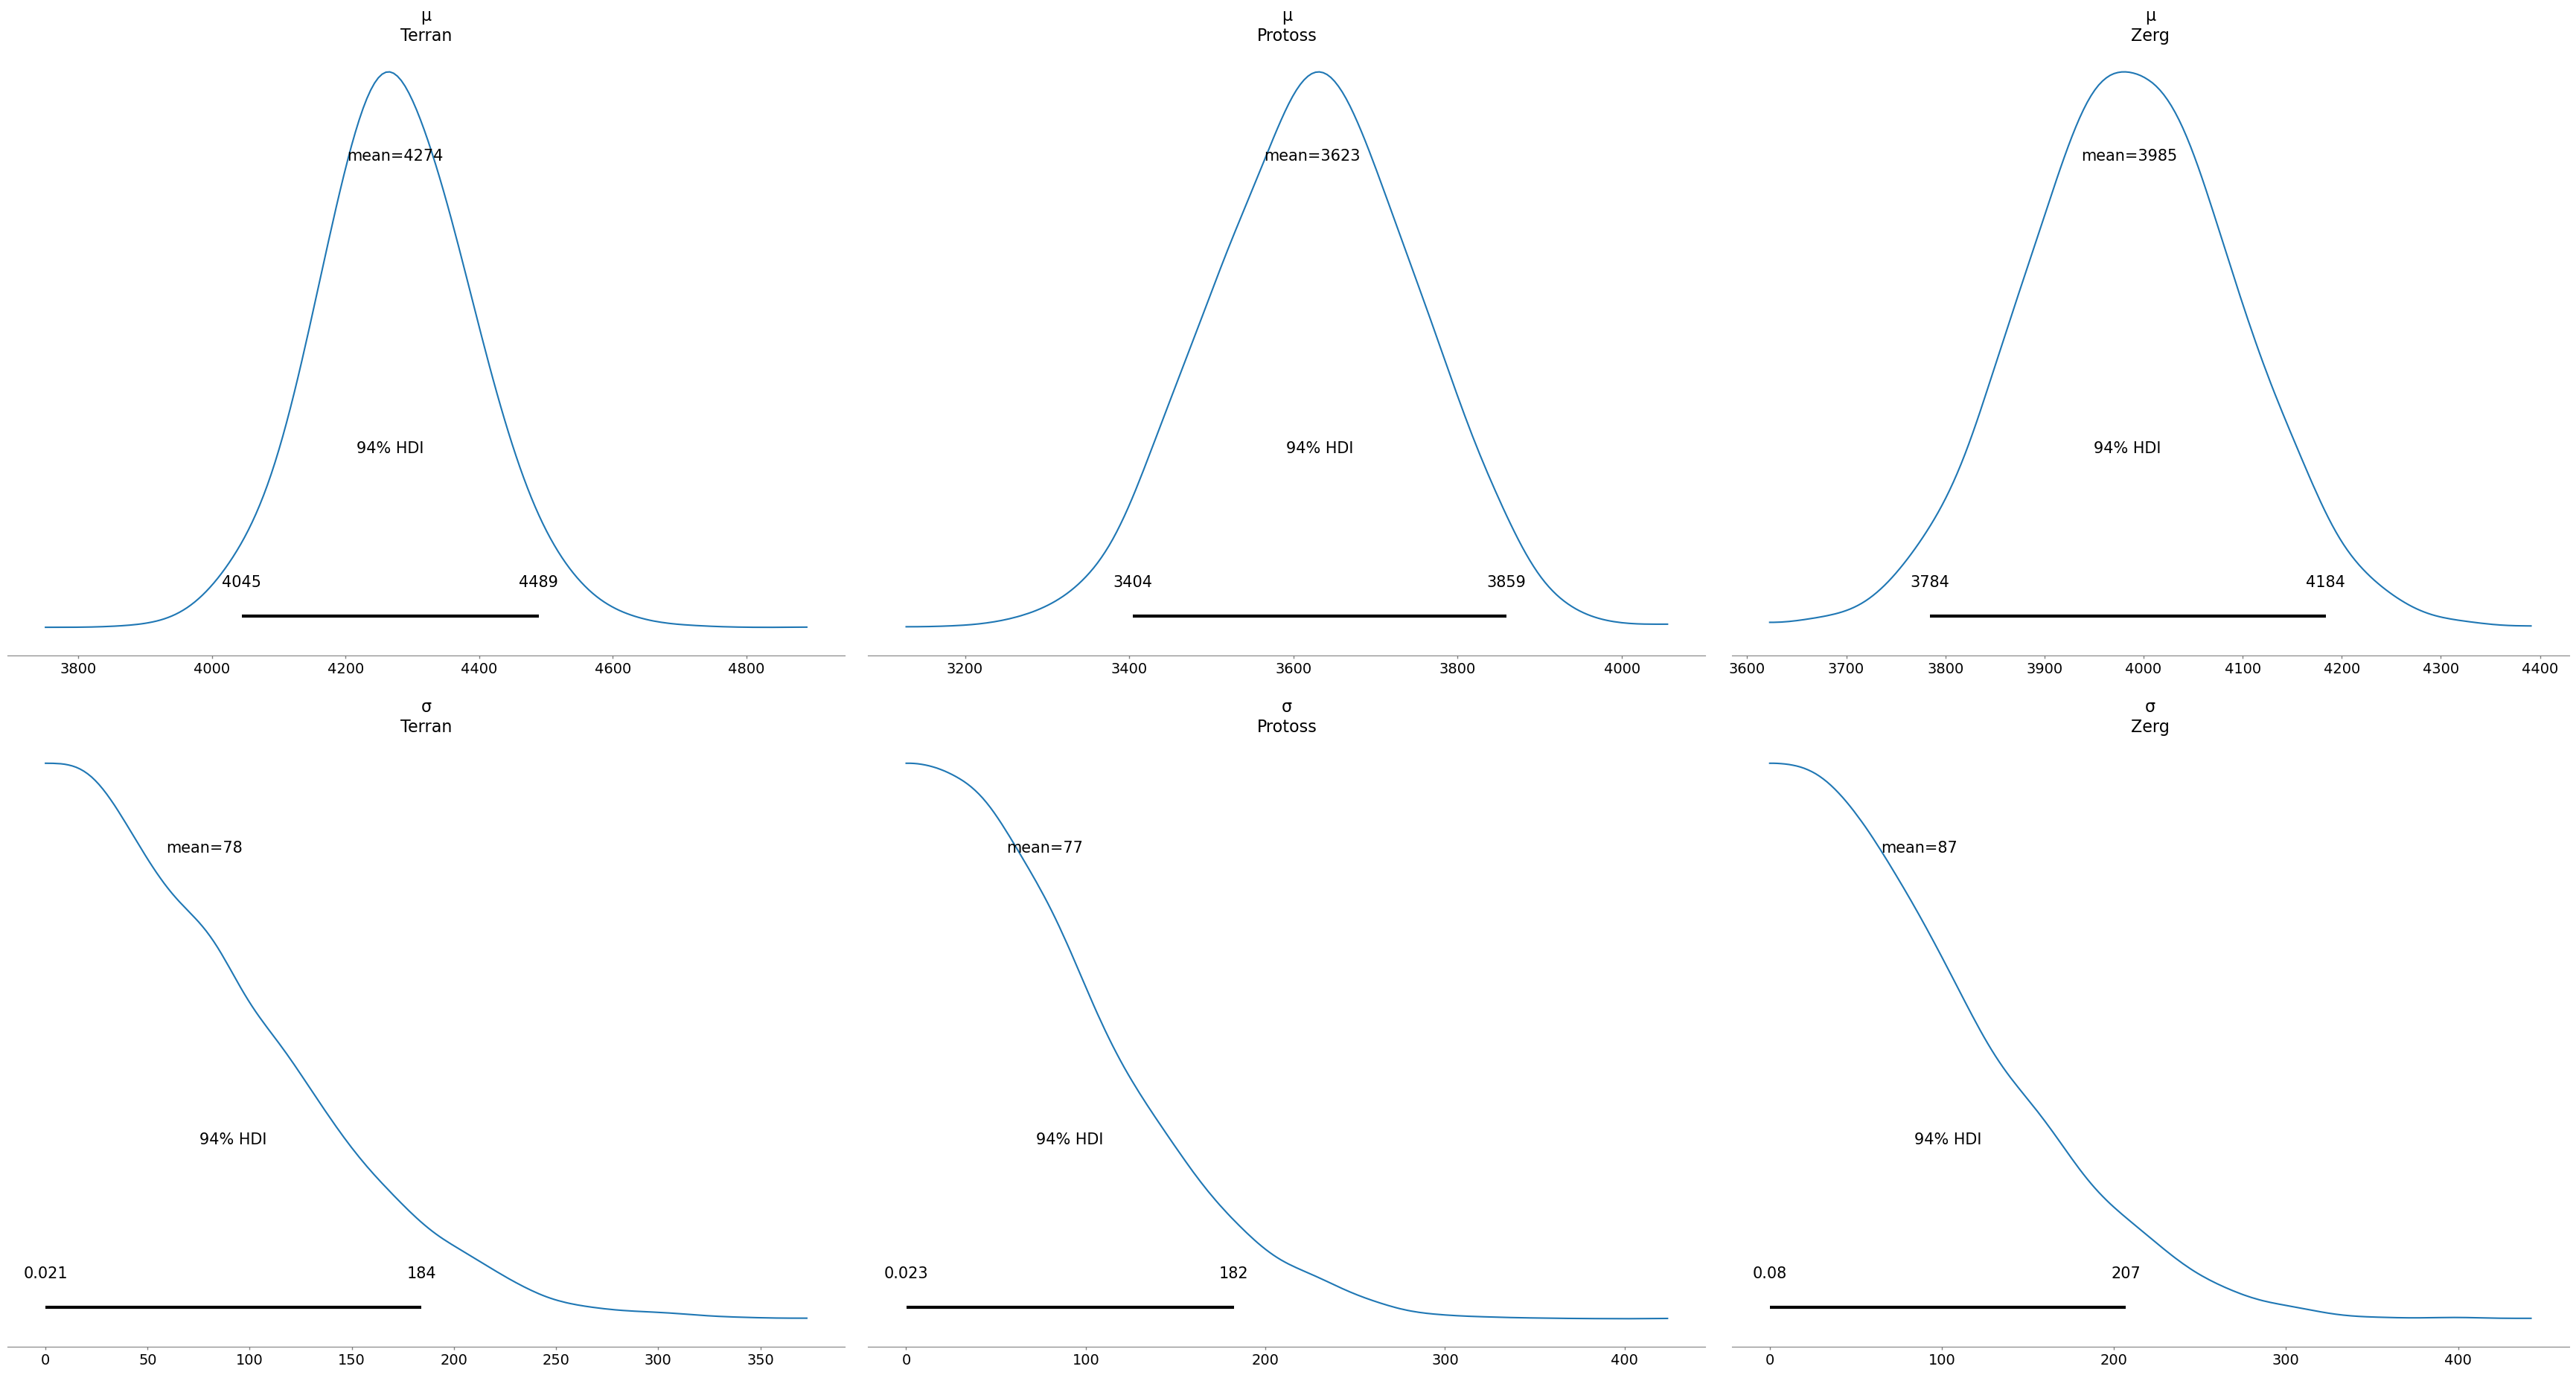

In [41]:
az.plot_posterior(output, var_names = var_names);

This already shows us two things:

* there are large differences in average MMR in the three matchups - as we had expected! This basically means I could go to TopTierPractice and use these MMR ranges to find practice partners at appropriate levels for the both of us. Interestingly, this means I should have been seeking better Terran players. (Note that this is last year's data).
* The versus Zerg fluctuations are a tad larger than against the other races; this would mean there are more confounding variables. Game duration could be a factor; I feel much more confident in the midgame than in the extreme lategame or against early rushes.

And this is honestly something you could start applying to your own data right now.
Now, what I was going to do was to also apply a **hierarchical model** to this data; but, since it turns out I don't really understand them all that well just yet, and I'm running out of time for my pre-set deadling for this post, I'll postpone that for the next week.

Instead, what we'll do is take a look at the current (this year's) data, using this exact same technique for a cheap replica of time dependence:

# Analysis repeated for 2020 (easy code snippet!)

In [45]:
data = all_data[(all_data['time_played_at'] > '2020-01-01')]
display(data)

,time_played_at,win,race,enemy_race,mmr,mmr_diff,enemy_nickname,map_name,duration,enemy_mmr,expected_winrate
265,2020-01-04 19:04:15+00:00,True,Protoss,Terran,4009,-29,Rêgo,Nightshade LE,935,4038,0.481039
223,2020-01-04 19:07:07+00:00,True,Protoss,Protoss,4031,-132,&lt;unƊeaƊ&gt;<sp/>òMégà,World of Sleepers LE,107,4163,0.414501
402,2020-01-04 19:19:31+00:00,False,Protoss,Terran,4057,-32,Tsumi,Eternal Empire LE,714,4089,0.479080
206,2020-01-05 14:03:19+00:00,False,Protoss,Zerg,4036,-160,&lt;Lowko&gt;<sp/>HardNeper,Eternal Empire LE,300,4196,0.396839
417,2020-01-05 14:18:07+00:00,True,Protoss,Terran,4019,14,delmak,Eternal Empire LE,867,4005,0.509157
...,...,...,...,...,...,...,...,...,...,...,...
1,2020-06-09 17:11:15+00:00,False,Protoss,Zerg,4186,39,djakette,Eternal Empire LE,420,4147,0.525489
210,2020-06-09 17:24:17+00:00,False,Protoss,Terran,4164,-68,StaMinA,Eternal Empire LE,758,4232,0.455635
188,2020-06-10 11:18:56+00:00,False,Protoss,Protoss,4144,-41,Guinness,Ice and Chrome LE,299,4185,0.473206
131,2020-06-10 11:27:56+00:00,False,Protoss,Terran,4125,125,Oink,Eternal Empire LE,211,4000,0.581047


In [46]:
brush = altair.selection(type='interval')
scatter = altair.Chart(data).mark_circle().encode(
    altair.X('enemy_mmr',
             scale=altair.Scale(zero=False)),
    altair.Y('mmr',
             scale=altair.Scale(zero=False)),
    facet='enemy_race',
    size='expected_winrate',
    color='win',
    tooltip='enemy_nickname',
).add_selection(brush)

bar = altair.Chart(data).mark_bar().encode(
    x=altair.X('mean(win):Q', scale=altair.Scale(domain=(0, 1))),
    y='enemy_race:O',
).transform_filter(brush)

scatter & bar

alt.VConcatChart(...)

In [47]:
import pymc3 as pm
import arviz as az

coords = {
    "replay": data.index,
    "race": ["Terran", "Protoss", "Zerg"],
}
race_encoding ={"Terran": 0,
                "Protoss": 1,
                "Zerg": 2} 


predictive_var_names = "win μ σ winrate".split()
with pm.Model(coords=coords) as split_model:
    mmr_μ_matchup = pm.Normal('μ', 4000, 300, dims='race')
    mmr_σ_matchup = pm.HalfNormal('σ', 100, dims='race')
    mmr_σ_norm = pm.Normal('helper', 0, 1, dims='replay')
    
    enemy_races = pm.Data("enemy_race", data.enemy_race.map(race_encoding).astype(int), dims='replay')
    mmr = pm.Deterministic('MMR', mmr_μ_matchup[enemy_races] + mmr_σ_matchup[enemy_races] * mmr_σ_norm, dims='replay')
    
    enemy_mmr = pm.Data("enemy_mmr", data.enemy_mmr, dims='replay')
    diffs = pm.Deterministic('MMR_diff', mmr - enemy_mmr, dims = 'replay')
    p = pm.Deterministic('winrate', MMR_winrate(diffs), dims = 'replay')
    wl = pm.Bernoulli('win', p=p, observed=data.win, dims = 'replay')
    
    trace = pm.sample(2000, tune=2000, chains=4, random_seed=1, target_accept=0.9)
    output = az.from_pymc3(trace=trace,
                           prior=pm.sample_prior_predictive(2000 , var_names=predictive_var_names, random_seed=1),
                           posterior_predictive=pm.sample_posterior_predictive(trace, var_names=predictive_var_names, random_seed=1),
                          )
output

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [helper, σ, μ]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 26 seconds.


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ[0],4187.331,93.433,4014.681,4370.002,0.827,0.588,12761.0,12620.0,12833.0,5208.0,1.0
μ[1],4014.234,97.855,3835.751,4202.949,0.837,0.592,13669.0,13643.0,13703.0,5413.0,1.0
μ[2],3961.245,88.126,3794.804,4122.579,0.716,0.516,15147.0,14584.0,15149.0,5685.0,1.0
σ[0],79.342,60.635,0.027,187.229,0.751,0.531,6516.0,6516.0,5236.0,3992.0,1.0
σ[1],80.221,59.112,0.003,184.095,0.694,0.491,7250.0,7250.0,5667.0,4667.0,1.0
σ[2],82.427,62.380,0.020,196.670,0.784,0.554,6330.0,6330.0,5219.0,4182.0,1.0


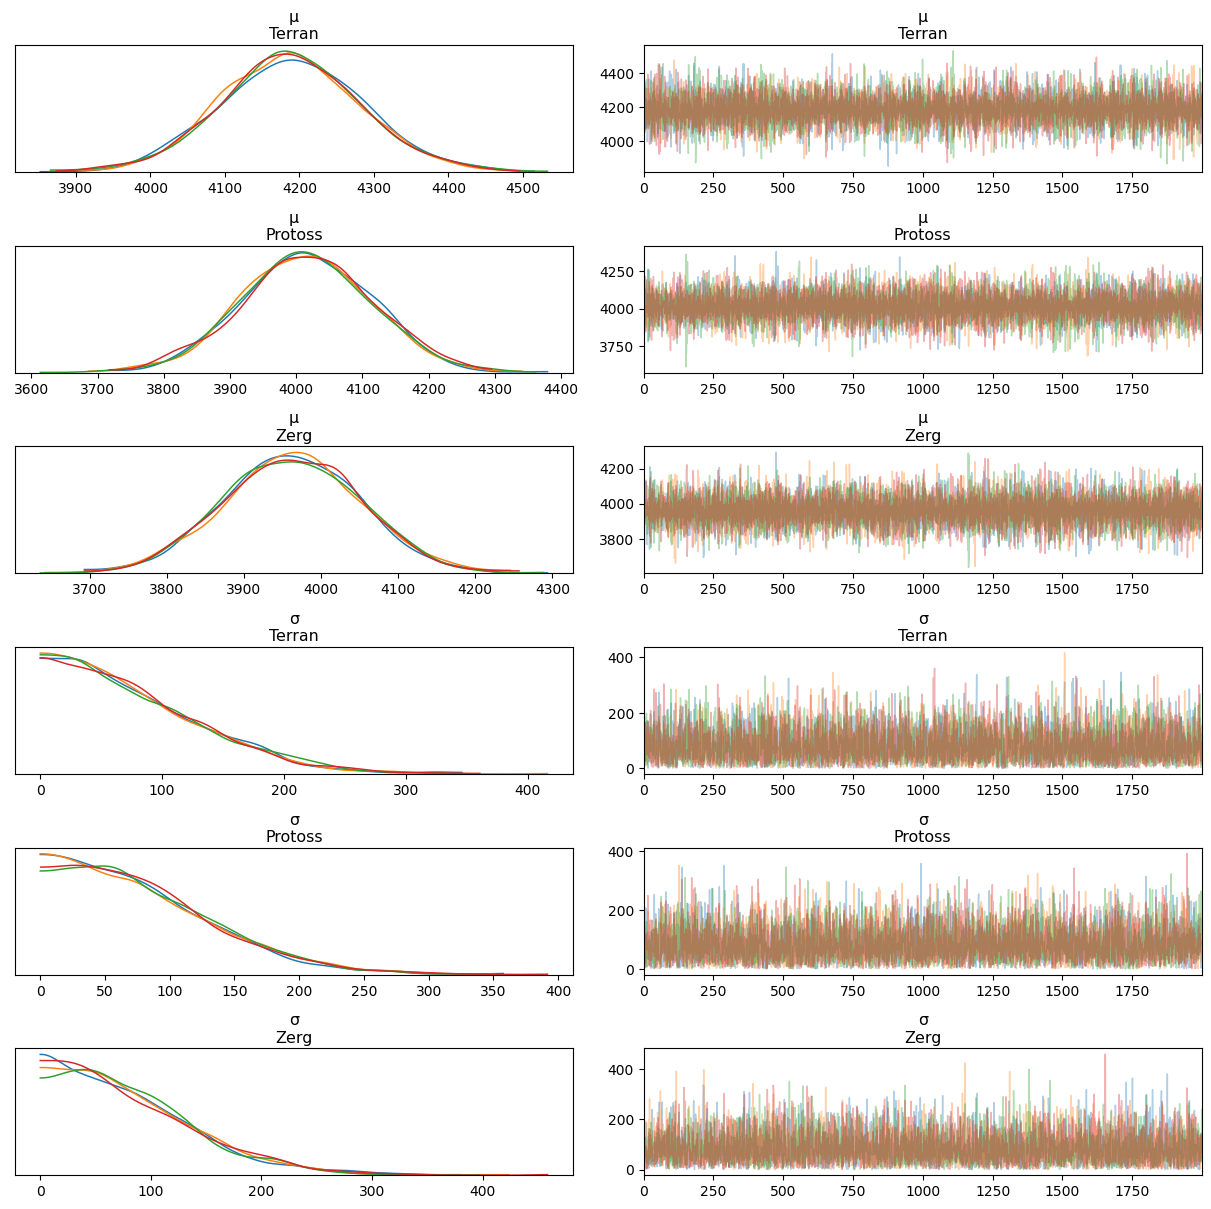

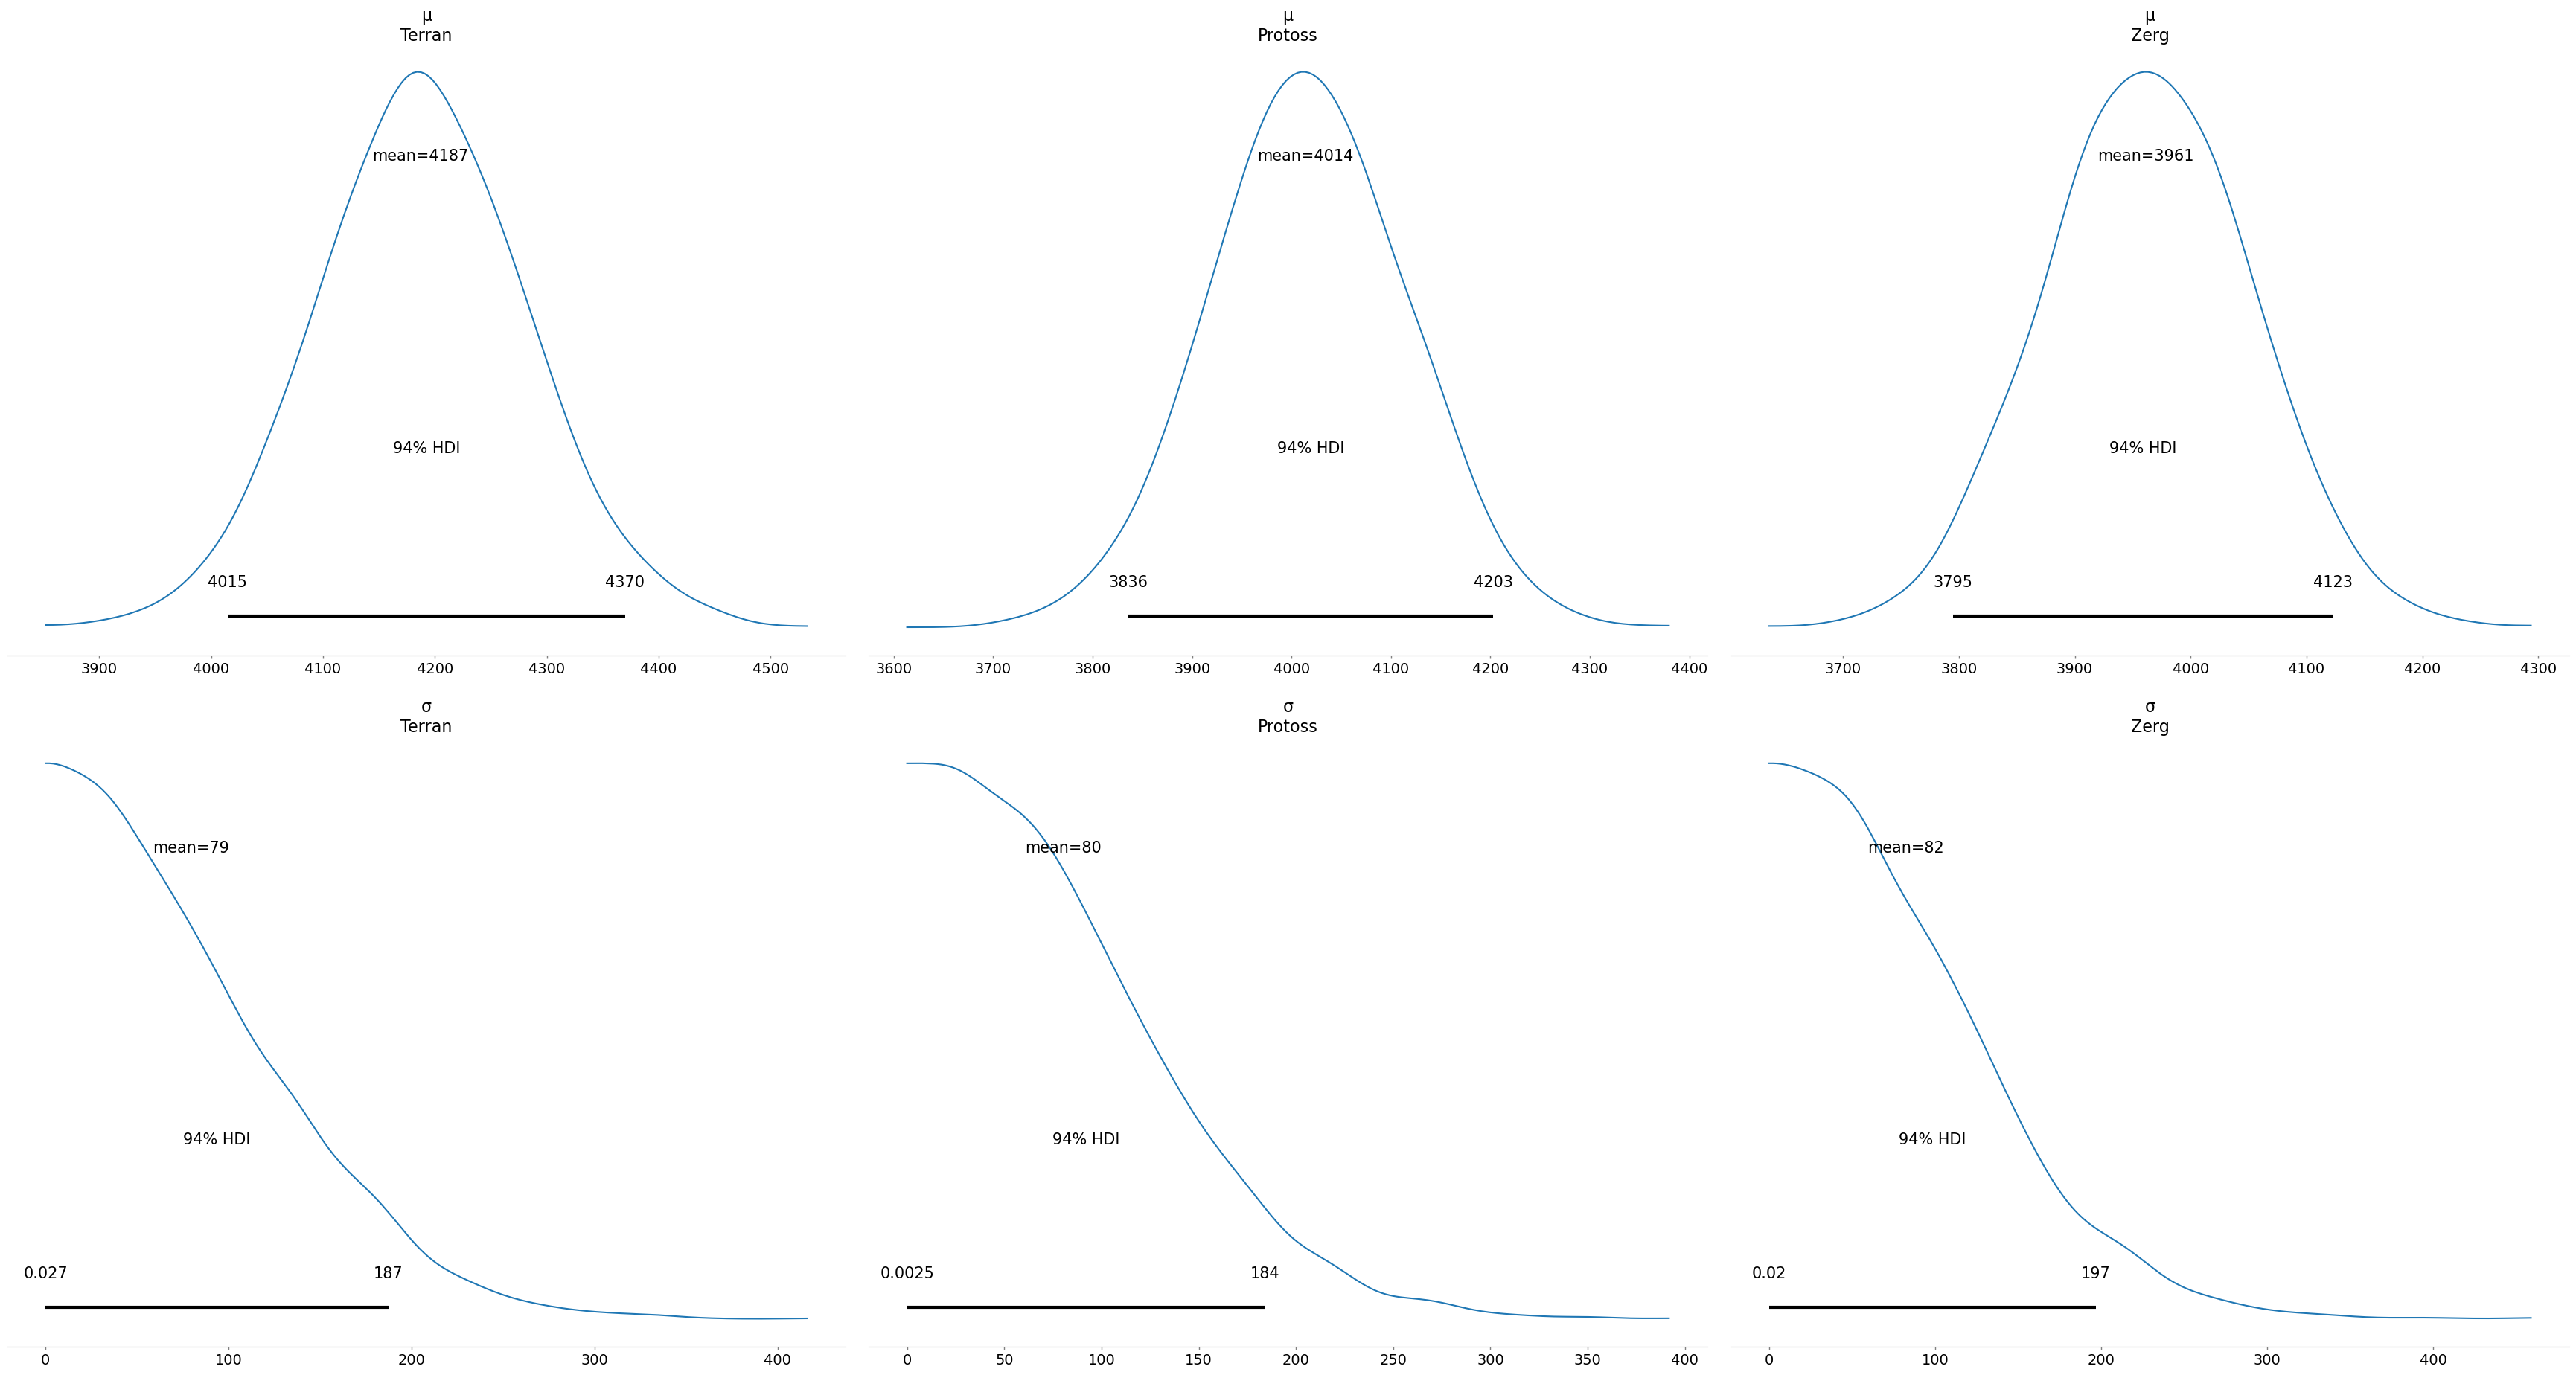

In [48]:
az.plot_trace(output, var_names=var_names);
az.plot_posterior(output, var_names = var_names);
az.summary(output, var_names = var_names)

And this seems to show I've grown more balanced as a player - the daily fluctuations are much more similar between games, I've gotten much better against Protoss, slightly worse against Terran, and my PvZ looks like it'll need some more work. Still, I'm really happy to see the data show I'm not as bad in PvP now!

For the next post, I'm torn between a few experiments I'm running:

* a hierarchical model to estimate both true global and per-matchup MMR at the same time while sharing information between the three matchups
* map dependence, which is going to be easy-ish now that I know how to index variables well
* actual time dependence, but I'll have to read up more on Gaussian processes and random walks to do that.
* playing around with prior- and posterior- predictive checks, which was going to be in this post, but it turns out I don't fully understand them enough yet. This will involve a foray into xarray - the awesome data structure that stores our results.

If you have any preference, please say so in the comments; I'll try to take it into account. Until the next time!